# Feature Engineering & Importance Testing

# 1. Loading data

In [ ]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load subset of the training data
X_train = pd.read_csv('../input/train.csv', nrows=1000000, parse_dates=['click_time'])

# Show the head of the table
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


# 2. Creating Features
## 2.1 Extracting time information
First extract day, minute, hour, second from the click_time.

In [ ]:
X_train['day'] = X_train['click_time'].dt.day.astype('uint8')
X_train['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_train['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_train['second'] = X_train['click_time'].dt.second.astype('uint8')
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,32,21
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,33,34
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,34,12
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,34,52
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,35,8


## 2.2. Confidence Rates for is_attributed
Calculating the "attributed rates":

\begin{equation}
\text{P}\,\text{(is_attributed}\,\,|\,\,\text{category)}
\end{equation}

or in some cases two- or multiple-paired combinations:

\begin{equation}
\text{P}\,\text{(is_attributed}\,\,|\,\,\text{category_1, category_2)}
\end{equation}

The danger of this is that if a given category-combination has very few clicks, then the statistical significance of above equations cannot be trusted. Therefore, weighing the rates by the following confidence rates:

\begin{equation}
    \text{conf}_{\text{is_attributed}} = \frac{\log(\text{views}_{\text{category_1}})}{\log(100000)}
\end{equation}

where the value 100000 has been chosen arbitrarily to such that if a given category has 1000 views, then it gets a confidence weight of 60%, if it has 100 views then onfly a confidence weight of 40% etc.

In [ ]:
ATTRIBUTION_CATEGORIES = [
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:

    # New feature name
    new_feature = '_'.join(cols)+'_confRate'

    # Perform the groupby
    group_object = X_train.groupby(cols)

    # Group sizes
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature,
        group_sizes.max(),
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))

    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf

    # Perform the merge
    X_train = X_train.merge(
        group_object['is_attributed']. \
            apply(rate_calculation). \
            reset_index(). \
            rename(
                index=str,
                columns={'is_attributed': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )

X_train.head()

>> Calculating confidence-weighted rate for: ['ip'].
   Saving to: ip_confRate. Group Max /Mean / Median / Min: 6437 / 25.25 / 10.0 / 1
>> Calculating confidence-weighted rate for: ['app'].
   Saving to: app_confRate. Group Max /Mean / Median / Min: 141851 / 4672.9 / 12.0 / 1
>> Calculating confidence-weighted rate for: ['device'].
   Saving to: device_confRate. Group Max /Mean / Median / Min: 938053 / 3355.7 / 1.0 / 1
>> Calculating confidence-weighted rate for: ['os'].
   Saving to: os_confRate. Group Max /Mean / Median / Min: 239642 / 6250.0 / 38.0 / 1
>> Calculating confidence-weighted rate for: ['channel'].
   Saving to: channel_confRate. Group Max /Mean / Median / Min: 92534 / 6493.51 / 1200.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'channel'].
   Saving to: app_channel_confRate. Group Max /Mean / Median / Min: 61413 / 1915.71 / 18.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'os'].
   Saving to: app_os_confRate. Group Max /Mean / Median / Min: 3485

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,app_confRate,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,0.000446,0.001193,0.001146,0.000497,0.000360,0.000366,0.000444,0.000000,0.000499,0.001182
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,0.000446,0.001193,0.001394,0.000497,0.000360,0.000275,0.000444,0.000235,0.000499,0.001428
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,0.000446,0.001193,0.001146,0.000497,0.000360,0.000366,0.000444,0.000000,0.000499,0.001182
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,0.000431,0.001193,0.001146,0.004071,0.004164,0.000201,0.000445,0.001835,0.004109,0.001182
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,0.000446,0.001193,0.001146,0.000497,0.000360,0.000366,0.000444,0.000000,0.000499,0.001182


## 2.3. Group-By-Aggregation

In [ ]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [

    # V1 - GroupBy Features #
    #########################
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'},

    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'],
     'select': 'ip',
     'agg': lambda x: float(len(x)) / len(x.unique()),
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},

    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ######################################################################
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'},
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'},
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'},
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'},
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'},
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'},
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'},
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'},
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'},
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'},
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:

    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']

    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])

    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))

    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))

    # Perform the groupby
    gp = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})

    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp[0].values
    else:
        X_train = X_train.merge(gp, on=spec['groupby'], how='left')

     # Clear memory
    del gp
    gc.collect()

X_train.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating ip with AvgViewPerDistinct
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nu

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_nunique_app,ip_day_nunique_hour,ip_app_nunique_os,ip_nunique_device,app_nunique_channel,ip_device_os_nunique_app,ip_device_os_cumcount_app,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour_y
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,19,2,5,1,34,16,0,0,0,1.333333
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,20,3,8,1,34,11,0,0,0,1.000000
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,17,2,6,3,34,10,0,0,0,2.000000
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,31,2,18,6,26,24,0,0,0,1.000000
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,1,1,1,1,34,1,0,0,0,NaN


# 2.4. Time till next click
It might be interesting to know e.g. how long it takes for a given ip-app-channel before they perform the next click.

In [ ]:
GROUP_BY_NEXT_CLICKS = [

    # V1
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},

    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:

    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))

    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']

    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    X_train[new_feature] = X_train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds

X_train.head()

>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick
>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to next click in: ip_app_device_os_channel_nextClick
>> Grouping by ['ip', 'os', 'device'], and saving time to next click in: ip_os_device_nextClick
>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to next click in: ip_os_device_app_nextClick


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour_y,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,0,0,1.333333,5290.0,5340.0,5444.0,5307.0,NaN,5307.0,5340.0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,0,0,1.000000,5177.0,5177.0,5177.0,5239.0,NaN,5239.0,5547.0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,0,0,2.000000,5175.0,5175.0,6005.0,5205.0,NaN,5205.0,5925.0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,0,0,1.000000,5108.0,5110.0,5137.0,5108.0,NaN,5108.0,5110.0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.5. Clicks on app ad before & after
Has the user previously or subsequently clicked the exact same app-device-os-channel?

In [ ]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():

    # Clicks in the past
    X_train['prev_'+fname] = X_train. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)

    # Clicks in the future
    X_train['future_'+fname] = X_train.iloc[::-1]. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]

# Count cumulative subsequent clicks
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,5340.0,5444.0,5307.0,NaN,5307.0,5340.0,0,0,0,18
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,5177.0,5177.0,5239.0,NaN,5239.0,5547.0,0,0,0,22
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,5175.0,6005.0,5205.0,NaN,5205.0,5925.0,0,0,0,9
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,5110.0,5137.0,5108.0,NaN,5108.0,5110.0,0,0,0,68
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


# 3. Evaluating Feature Importance
Having created heaps of features, I'll fit xgBoost to the data, and evaluate the feature importances. First split into X and y

In [ ]:
import xgboost as xgb

# Split into X and y
y = X_train['is_attributed']
X = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])

# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4,
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=0, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=4, reg_lambda=1, scale_pos_weight=9, seed=None,
       silent=True, subsample=0.8)

The feature importances are MinMax scaled, put into a DataFrame, and finally plotted ordered by the mean feature importance.

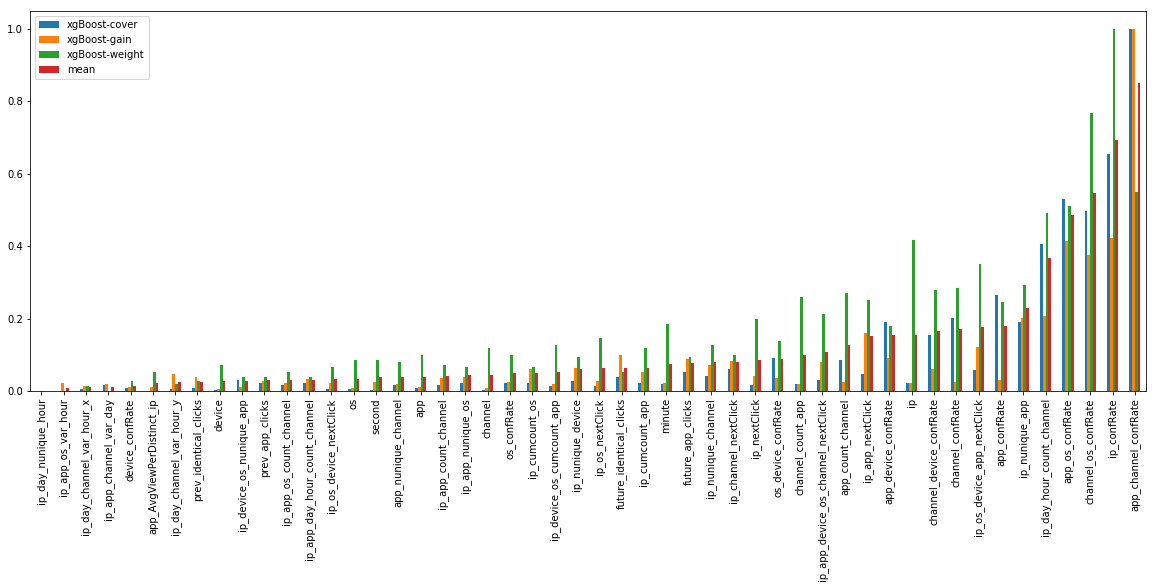

In [ ]:
from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)

# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))